In [ ]:
!pip install -q pyspark

!wget -q 'https://drive.google.com/uc?export=download&id=12FwbWd06qSekQlZXCOreSZQ1OOUgeOOD' -O 'Diabetes.csv'


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col

In [ ]:
file=pd.read_csv('Diabetes.csv')

In [ ]:
file.head().T

,0,1,2,3,4
Pregnancies,6.000,1.000,8.000,1.000,0.000
Glucose,148.000,85.000,183.000,89.000,137.000
BloodPressure,72.000,66.000,64.000,66.000,40.000
SkinThickness,35.000,29.000,0.000,23.000,35.000
Insulin,0.000,0.000,0.000,94.000,168.000
BMI,33.600,26.600,23.300,28.100,43.100
DiabetesPedigreeFunction,0.627,0.351,0.672,0.167,2.288
Age,50.000,31.000,32.000,21.000,33.000
Outcome,1.000,0.000,1.000,0.000,1.000


In [ ]:
file.shape

(768, 9)

In [ ]:
file.describe([0.1,0.25,0.5,0.75,0.9])

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
10%,0.000000,85.000000,54.000000,0.000000,0.000000,23.600000,0.165000,22.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
90%,9.000000,167.000000,88.000000,40.000000,210.000000,41.500000,0.878600,51.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


From above table we can see that minimum values for columns such as Glucose, BP, insulin, BMI are 0. Hence, there must be missing values and to deal with these values we can use some imputation techniques.

In [ ]:
corrupted_file = file.loc[:,'Glucose':'BMI']

In [ ]:
corrupted_file.replace(0,np.nan,inplace=True)

In [ ]:
file.loc[:,'Glucose':'BMI'] = corrupted_file

In [ ]:
file.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,763.000000,733.000000,541.000000,394.000000,757.000000,768.000000,768.000000,768.000000
mean,3.845052,121.686763,72.405184,29.153420,155.548223,32.457464,0.471876,33.240885,0.348958
std,3.369578,30.535641,12.382158,10.476982,118.775855,6.924988,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,64.000000,22.000000,76.250000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,29.000000,125.000000,32.300000,0.372500,29.000000,0.000000
75%,6.000000,141.000000,80.000000,36.000000,190.000000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [ ]:
file.isnull().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

Let's now find correlation between these missing values 

In [ ]:
import missingno as msno

<Axes: >

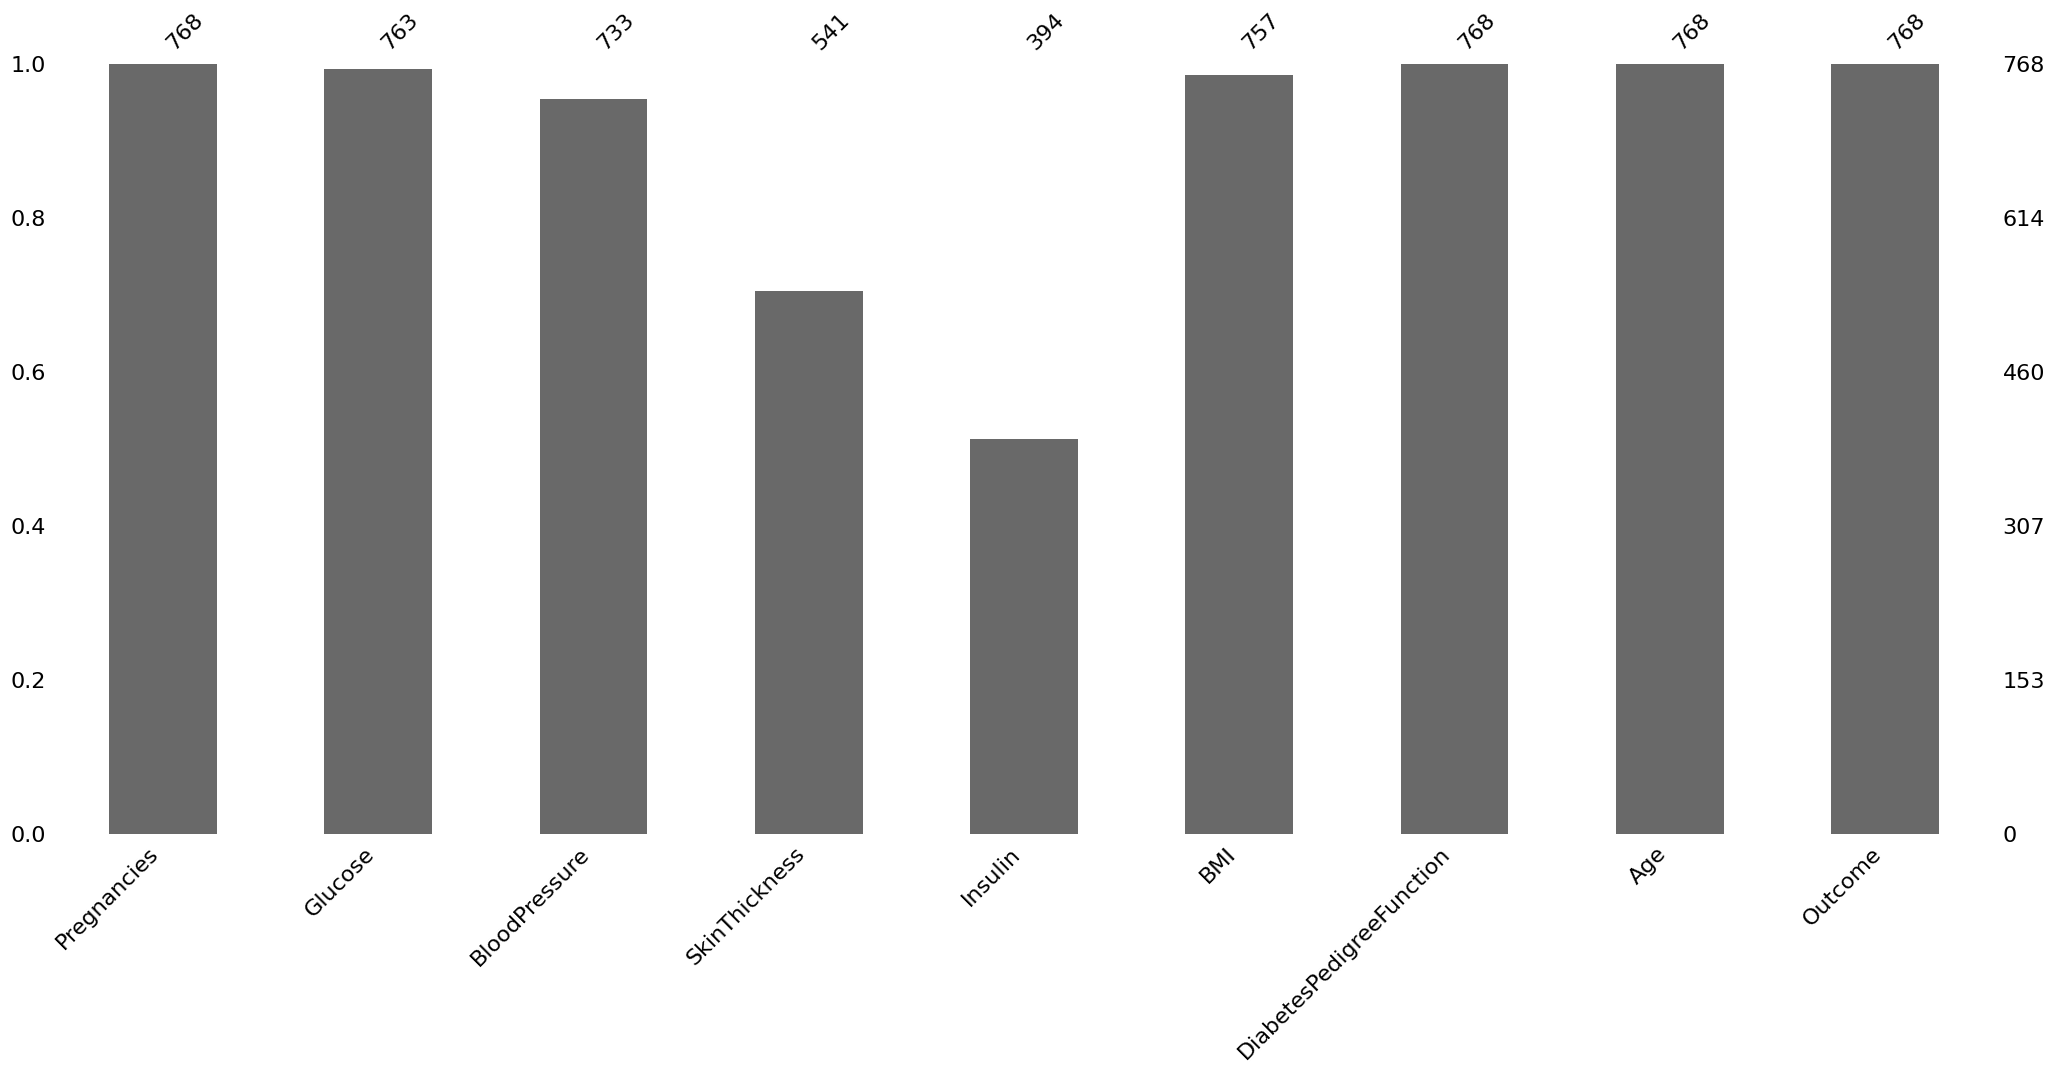

In [ ]:
msno.bar(file)

<Axes: >

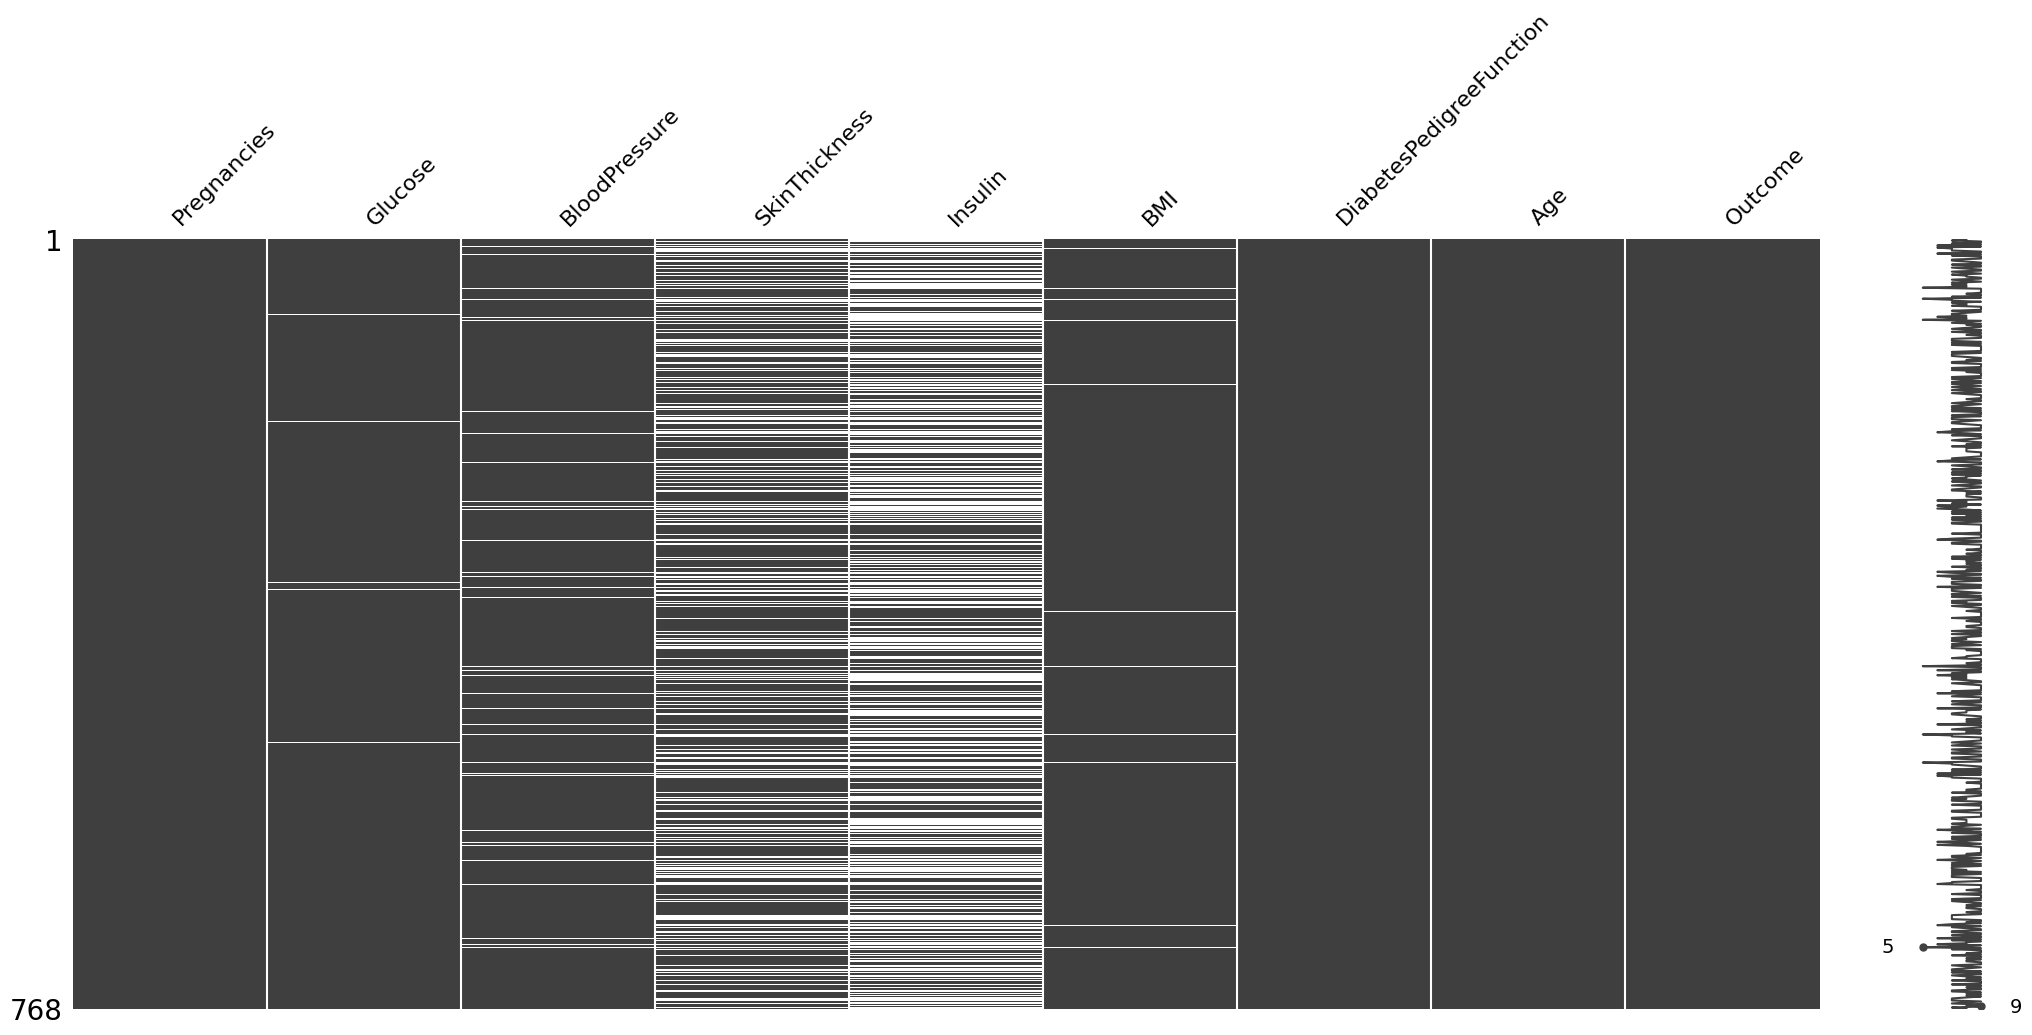

In [ ]:
msno.matrix(file)

<Axes: >

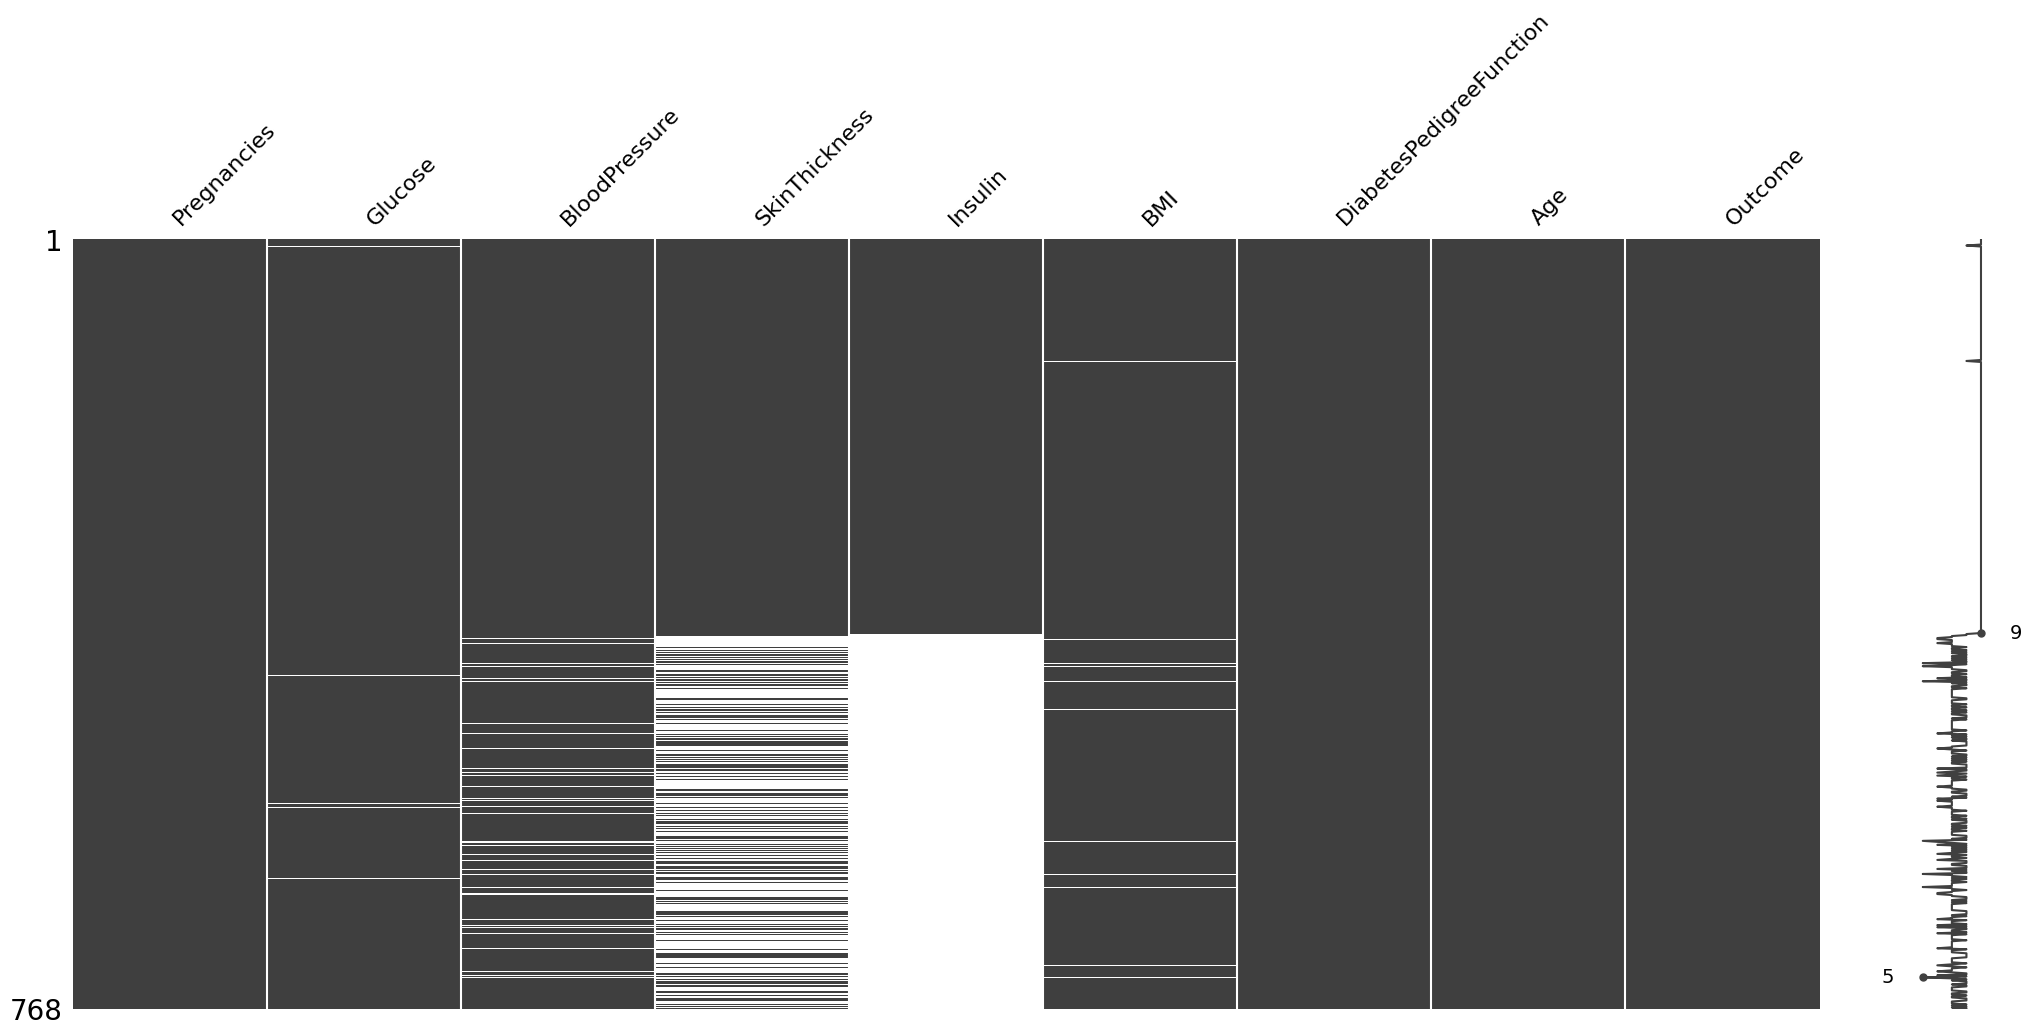

In [ ]:
msno.matrix(file.sort_values(by="Insulin"))

According to the aforementioned matrix, skin thickness, insulin, and glucose are all completely missing at random (MCAR) (Missing not at random)

<Axes: >

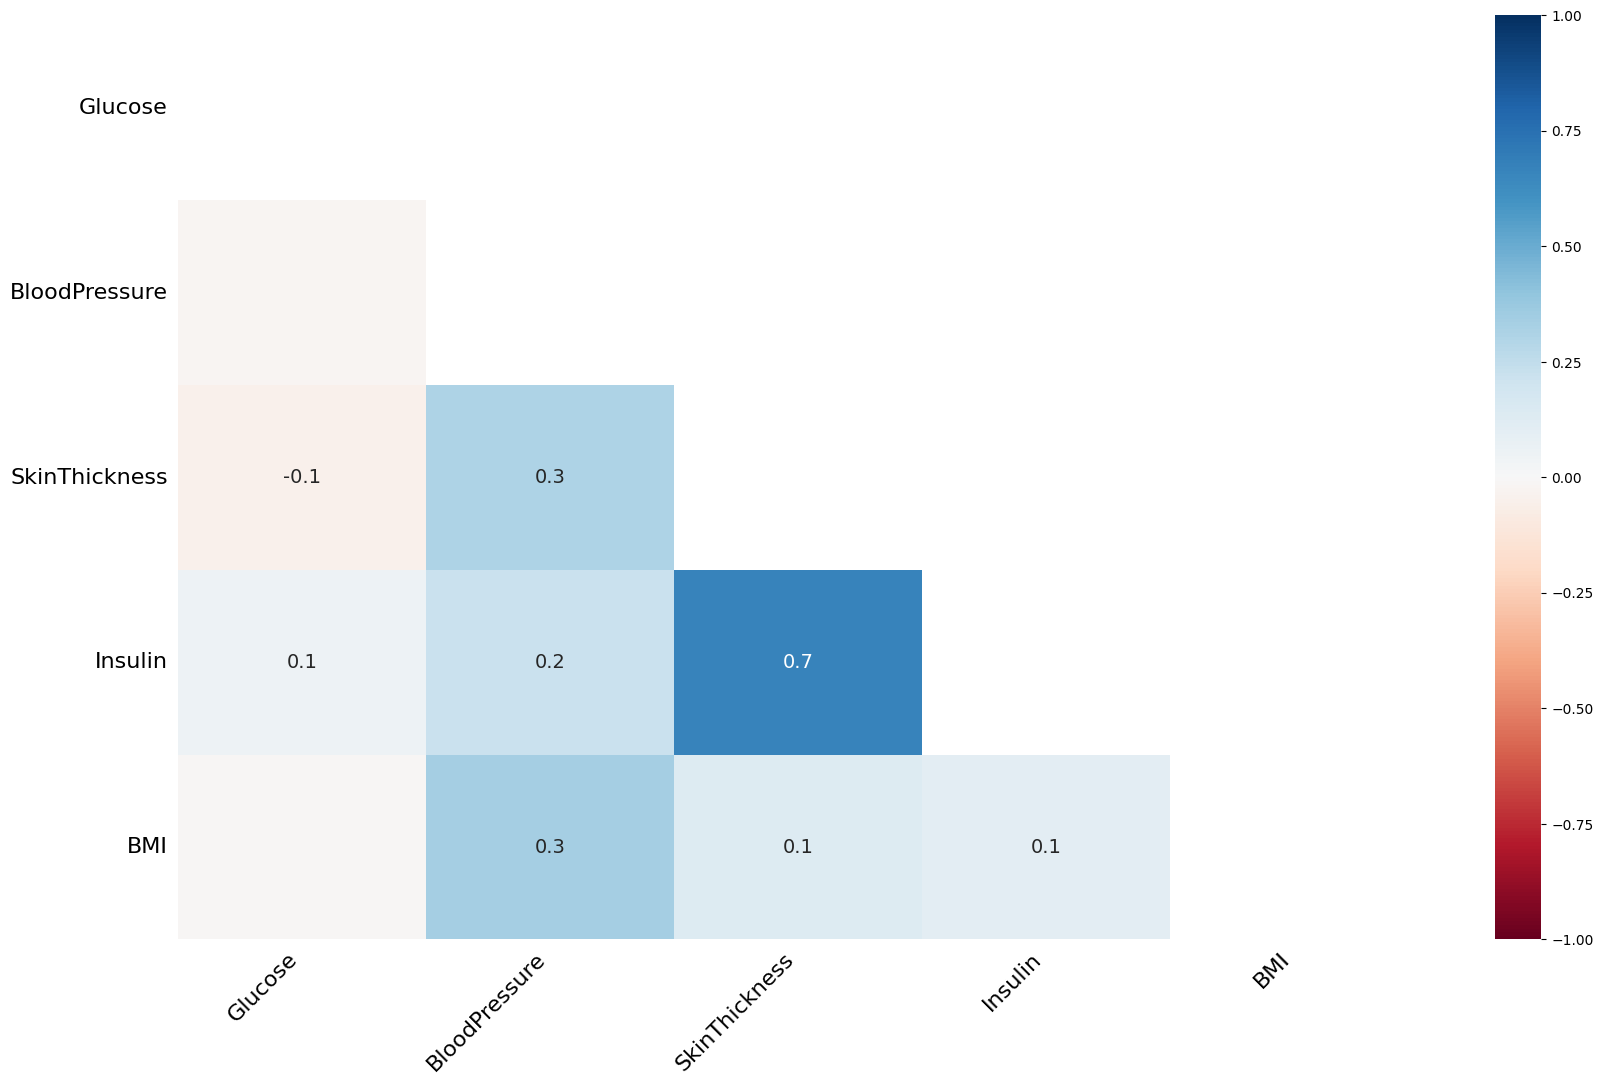

In [ ]:
msno.heatmap(file)



```
# This is formatted as code
```

There is a strong relationship between Insulin and SkinThickness.

In [ ]:
file.dropna(subset=['Glucose','BMI'],inplace=True) 

Knnimputer is used to fill in the missing values without affecting the dataset's variability.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

In [ ]:
from sklearn.impute import KNNImputer

In [ ]:
file_knn = file.copy()

In [ ]:
from sklearn.impute import KNNImputer
n_neighbors = 5

knn_imputer = KNNImputer(n_neighbors=n_neighbors)

file_knn_imputed = knn_imputer.fit_transform(file_knn)


In [ ]:
file_knn.shape

(752, 9)

In [ ]:
file_knn.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,752.000000,752.000000,724.000000,534.000000,392.000000,752.000000,752.000000,752.000000,752.000000
mean,3.851064,121.941489,72.400552,29.172285,156.056122,32.454654,0.473051,33.312500,0.351064
std,3.375189,30.601198,12.379870,10.507582,118.841690,6.928926,0.330108,11.709395,0.477621
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,22.000000,76.750000,27.500000,0.244000,24.000000,0.000000
50%,3.000000,117.000000,72.000000,29.000000,125.500000,32.300000,0.377000,29.000000,0.000000
75%,6.000000,141.000000,80.000000,36.000000,190.000000,36.600000,0.627500,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [ ]:
cleaned_file = file_knn.copy()

OUTLIER REMOVAL

<Axes: xlabel='Pregnancies'>

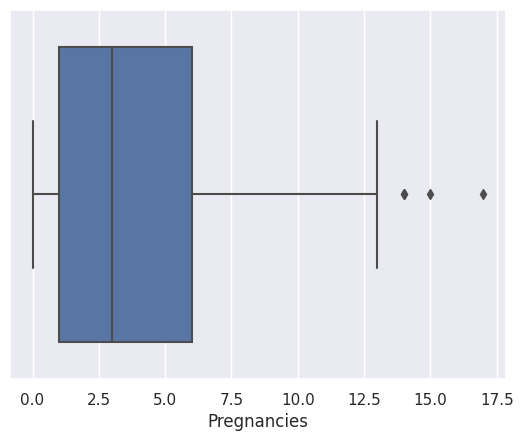

In [ ]:
sns.boxplot(data=file_knn,x='Pregnancies')

In [ ]:
cleaned_file = cleaned_file[cleaned_file['Pregnancies']<=13]

<Axes: xlabel='Glucose'>

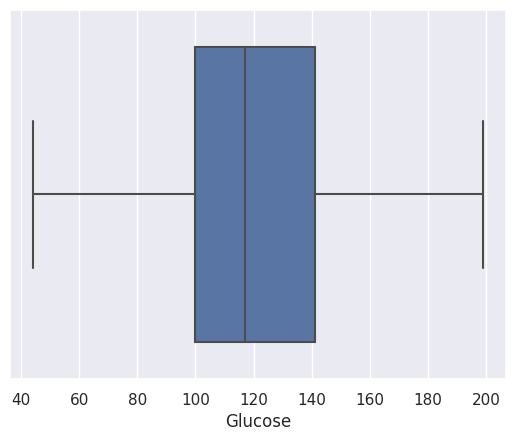

In [ ]:
sns.boxplot(data=file_knn,x='Glucose')

<Axes: xlabel='BloodPressure'>

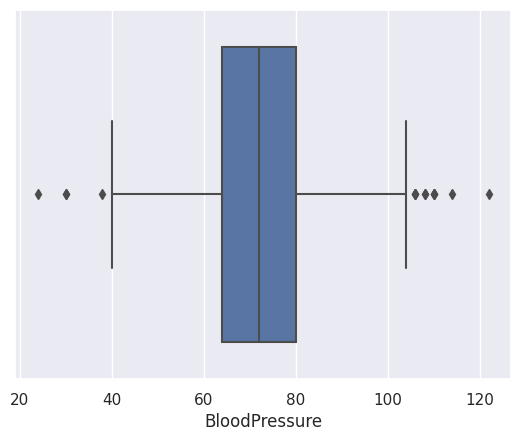

In [ ]:
sns.boxplot(data=file_knn,x='BloodPressure')

In [ ]:
cleaned_file = cleaned_file[cleaned_file['BloodPressure']>=30]

<Axes: xlabel='Insulin'>

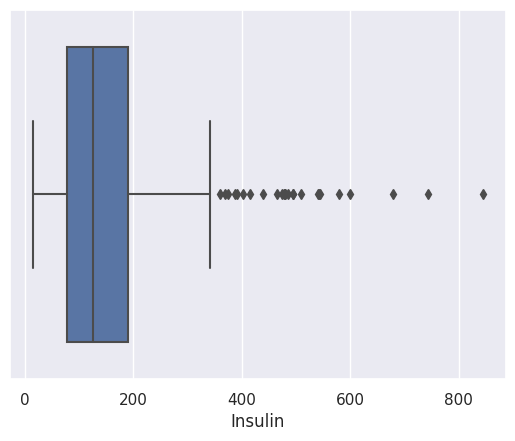

In [ ]:
sns.boxplot(data=file_knn,x='Insulin')

In [ ]:
cleaned_file = cleaned_file[cleaned_file['Insulin']<=500]

<Axes: xlabel='SkinThickness'>

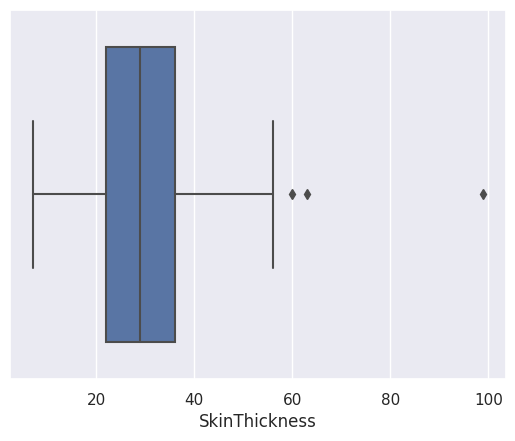

In [ ]:
sns.boxplot(data=file_knn,x='SkinThickness')

In [ ]:
cleaned_file = cleaned_file[cleaned_file['SkinThickness']<=80]

<Axes: xlabel='BMI'>

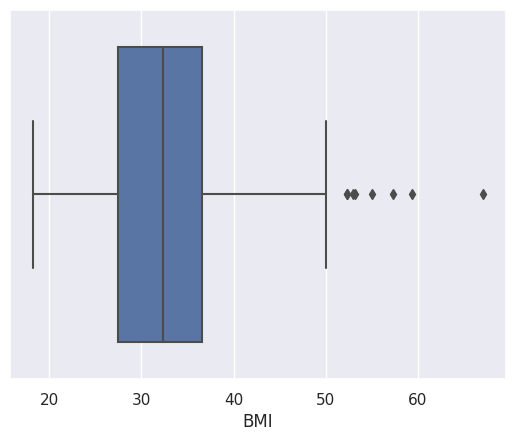

In [ ]:
sns.boxplot(data=file_knn,x='BMI')

In [ ]:
cleaned_file = cleaned_file[cleaned_file['BMI']<=60]

<Axes: xlabel='Age'>

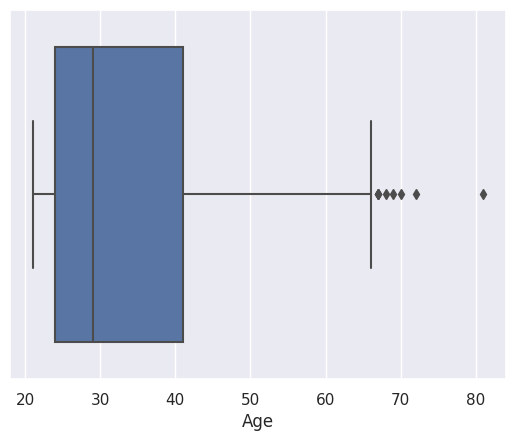

In [ ]:
sns.boxplot(data=file_knn,x='Age')

In [ ]:
cleaned_file = cleaned_file[cleaned_file['Age']<=70]

In [ ]:
print("Removed",file_knn.shape[0]-cleaned_file.shape[0],"outliers")

Removed 375 outliers


<Axes: >

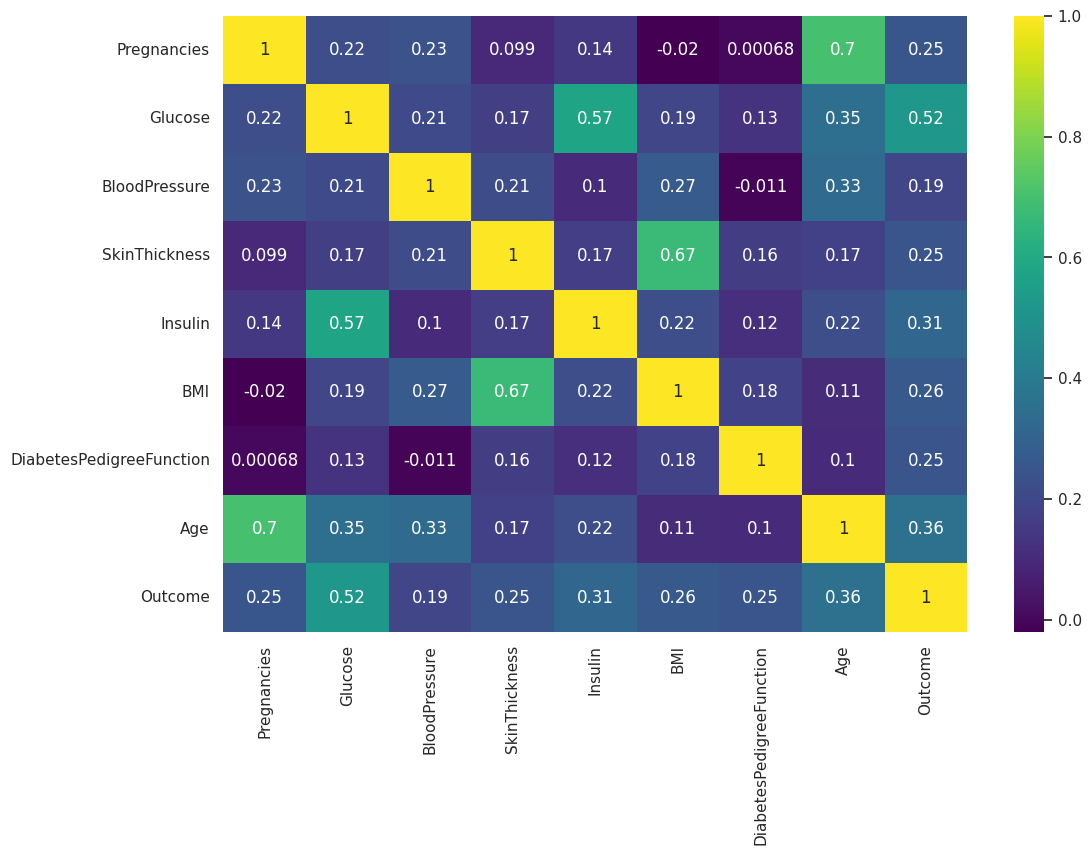

In [ ]:
plt.figure(figsize=(12,8))
sns.heatmap(cleaned_file.corr(),annot=True,cmap='viridis')

Conclusions of above HeatMap: 
1) The fact that type 1 diabetes patients, who typically have high Glucose, received Insulin injections may account for the positive association between Insulin and Glucose.
2) Moreover, glucose correlates with our results; for example, diabetic patients have greater blood glucose levels.

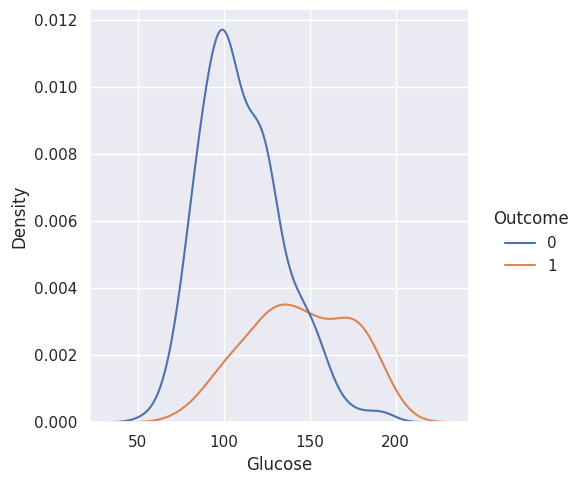

In [ ]:
sns.displot(data=cleaned_file,x='Glucose',hue='Outcome',kind='kde')

CONCLUSION:

Normal glucose distribution in people without diabetes is about 100, while normal glucose levels in those with diabetes range from 100 to 200.

<Axes: xlabel='Glucose', ylabel='Insulin'>

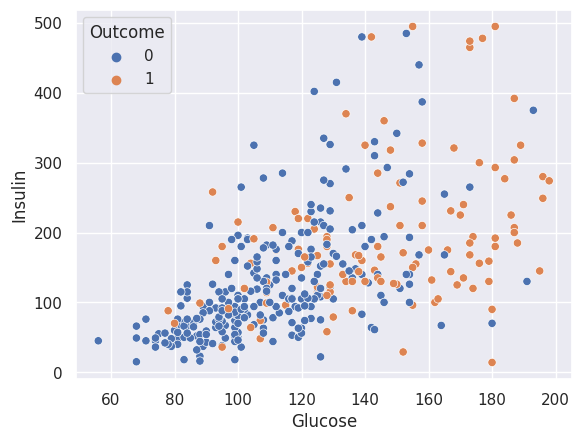

In [ ]:
sns.scatterplot(data=cleaned_file,x='Glucose',y='Insulin',hue='Outcome')

The scatterplot clearly shows that diabetic people have high glucose and low insulin levels because type 2 diabetes is produced when the pancreas produces very little to no insulin, which causes the amount of glucose to increase.

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.linalg import Vectors
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("Diabetes_DT").getOrCreate()
def create_feature_vector(row):
   features = [row['Pregnancies'], row['Glucose'], row['BloodPressure'], row['SkinThickness'], row['Insulin'],row['BMI'], row['DiabetesPedigreeFunction'], row['Age']]
   return(row['Outcome'], Vectors.dense(features))
df = spark.createDataFrame(cleaned_file)
rdd = df.rdd

rdd = rdd.map(create_feature_vector)

#rdd.collect()[:5]

[(0, DenseVector([1.0, 89.0, 66.0, 23.0, 94.0, 28.1, 0.167, 21.0])),
 (1, DenseVector([0.0, 137.0, 40.0, 35.0, 168.0, 43.1, 2.288, 33.0])),
 (1, DenseVector([3.0, 78.0, 50.0, 32.0, 88.0, 31.0, 0.248, 26.0])),
 (1, DenseVector([5.0, 166.0, 72.0, 19.0, 175.0, 25.8, 0.587, 51.0])),
 (1, DenseVector([0.0, 118.0, 84.0, 47.0, 230.0, 45.8, 0.551, 31.0]))]

In [ ]:
train_data_rdd, test_data_rdd = rdd.randomSplit([0.8, 0.2], seed=30)

train_data_df = spark.createDataFrame(train_data_rdd, ["label", "features"])
test_data_df = spark.createDataFrame(test_data_rdd, ["label", "features"])


In [ ]:
dt = DecisionTreeClassifier(featuresCol="features", labelCol="label")

model = dt.fit(train_data_df)

predictions = model.transform(test_data_df)




In [ ]:
#predictions.select("prediction", "label", "features").show(5)



+----------+-----+--------------------+
|prediction|label|            features|
+----------+-----+--------------------+
|       0.0|    1|[3.0,78.0,50.0,32...|
|       0.0|    1|[0.0,118.0,84.0,4...|
|       0.0|    0|[1.0,103.0,30.0,3...|
|       0.0|    1|[1.0,115.0,70.0,3...|
|       0.0|    1|[10.0,125.0,70.0,...|
+----------+-----+--------------------+
only showing top 5 rows



In [ ]:
#Features Information Gain
print(model.featureImportances)

(8,[0,1,2,3,4,5,6,7],[0.05405846677444852,0.4325172207544078,0.08706788873243305,0.009726210764440328,0.05795312840529429,0.1600272120652327,0.1312264862488623,0.06742338625488098])


In [ ]:
from pyspark.ml.classification import DecisionTreeClassificationModel, DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz


# Split the data into training and test sets
train_data_rdd, test_data_rdd = rdd.randomSplit([0.8, 0.2], seed=30)
train_data_df = spark.createDataFrame(train_data_rdd, ["label", "features"])
test_data_df = spark.createDataFrame(test_data_rdd, ["label", "features"])

# Define the decision tree model
dt = DecisionTreeClassifier(featuresCol="features", labelCol="label")

# Fit the model to the training data
model = dt.fit(train_data_df)
model.save("/content/saved/model")



In [ ]:
!pip install graphviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from pyspark.ml.classification import DecisionTreeClassificationModel
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from graphviz import Digraph

# load the trained model
model = DecisionTreeClassificationModel.load("/content/saved/model")

# print the decision tree
print(model.toDebugString)

# evaluate the model on test data
predictions = model.transform(test_data_df)
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Accuracy = %g" % accuracy)



DecisionTreeClassificationModel: uid=DecisionTreeClassifier_c15e3cc4a4f4, depth=5, numNodes=39, numClasses=2, numFeatures=8
  If (feature 1 <= 127.5)
   If (feature 6 <= 0.6545000000000001)
    If (feature 5 <= 46.2)
     Predict: 0.0
    Else (feature 5 > 46.2)
     If (feature 0 <= 1.5)
      Predict: 1.0
     Else (feature 0 > 1.5)
      Predict: 0.0
   Else (feature 6 > 0.6545000000000001)
    If (feature 5 <= 31.75)
     If (feature 0 <= 4.5)
      If (feature 5 <= 23.5)
       Predict: 1.0
      Else (feature 5 > 23.5)
       Predict: 0.0
     Else (feature 0 > 4.5)
      If (feature 4 <= 137.5)
       Predict: 0.0
      Else (feature 4 > 137.5)
       Predict: 1.0
    Else (feature 5 > 31.75)
     If (feature 4 <= 65.5)
      Predict: 0.0
     Else (feature 4 > 65.5)
      If (feature 2 <= 87.0)
       Predict: 1.0
      Else (feature 2 > 87.0)
       Predict: 0.0
  Else (feature 1 > 127.5)
   If (feature 5 <= 29.4)
    If (feature 7 <= 26.5)
     Predict: 0.0
    Else (feature 

In [ ]:
#Evaluate Model
TN = predictions.filter('prediction = 0 AND label = prediction').count()
TP = predictions.filter('prediction = 1 AND label = prediction').count()
FN = predictions.filter('prediction = 0 AND label != prediction').count()
FP = predictions.filter('prediction = 1 AND label != prediction').count()

# Accuracy measures the proportion of correct predictions
accuracy = (TN+TP)/(TN+TP+FN+FP)
print("Accuracy: {:.2f}".format(accuracy))


Accuracy: 0.73


In [ ]:
train_data_df.columns

['label', 'features']

In [ ]:
# Generate the classification report
from pyspark.sql.functions import col
from pyspark.sql.functions import expr
from pyspark.sql.functions import sum as spark_sum

tp = predictions.filter(col('label') == 1).filter(col('prediction') == 1).count()
tn = predictions.filter(col('label') == 0).filter(col('prediction') == 0).count()
fp = predictions.filter(col('label') == 0).filter(col('prediction') == 1).count()
fn = predictions.filter(col('label') == 1).filter(col('prediction') == 0).count()

precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * ((precision * recall) / (precision + recall))

print("Classification Report")
print("Precision: {:.2f}%".format(precision * 100))
print("Recall: {:.2f}%".format(recall * 100))
print("F1 Score: {:.2f}%".format(f1_score * 100))

Classification Report
Precision: 57.14%
Recall: 66.67%
F1 Score: 61.54%


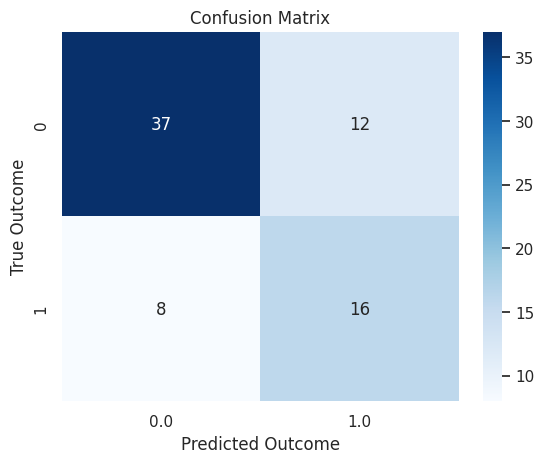

In [ ]:
conf_mat = predictions.groupBy("label", "prediction").count().orderBy("label", "prediction").toPandas()
conf_mat = conf_mat.pivot(index="label", columns="prediction", values="count")
sns.heatmap(conf_mat, annot=True, cmap='Blues', fmt='g')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Outcome")
plt.ylabel("True Outcome")
plt.show()

Area Under ROC Curve (AUC-ROC): 0.6926020408163266


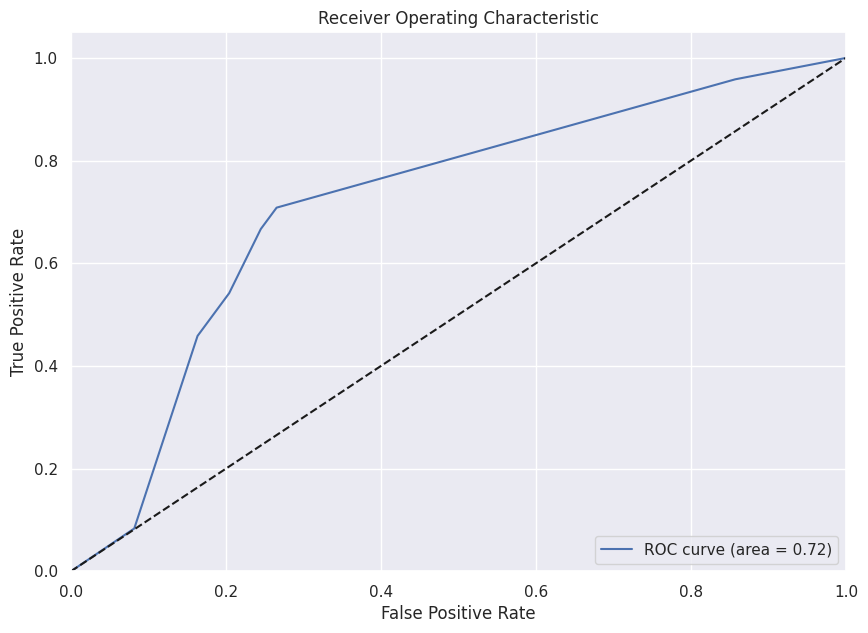

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
auc = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})
print("Area Under ROC Curve (AUC-ROC):", auc)

roc_df = predictions.select(['label', 'probability']).toPandas()

# Plot ROC curve
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(roc_df['label'], roc_df['probability'].apply(lambda x: x[1]))
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


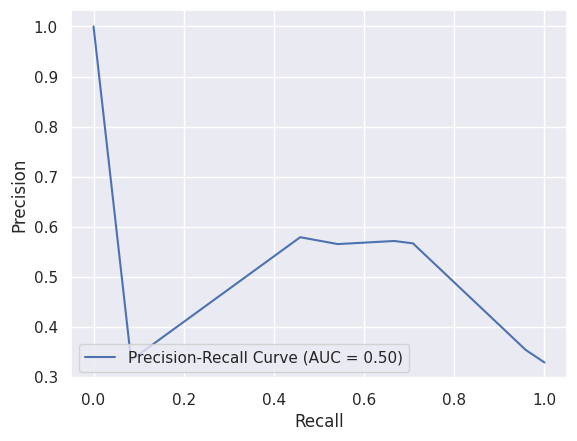

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc


# Get true labels and probability estimates
y_test = predictions.select(['label']).collect()
y_prob = predictions.select(['probability']).collect()

y_test = [int(i.label) for i in y_test]
y_prob = [float(i.probability[1]) for i in y_prob]

# Calculate precision-recall curve values
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

# Calculate area under the curve (AUC) for precision-recall curve
auc_score = auc(recall, precision)

# Plot precision-recall curve
plt.plot(recall, precision, label='Precision-Recall Curve (AUC = %0.2f)' % auc_score)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc="lower left")
plt.show()
